<a href="https://colab.research.google.com/github/antoinemarchal/GASKAP/blob/master/Copy_of_GASKAP_absorption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf GASKAP
!git clone https://github.com/antoinemarchal/GASKAP
import os
os.chdir('GASKAP')
!pip install .

Cloning into 'GASKAP'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 45 (delta 17), reused 35 (delta 9), pack-reused 0
Unpacking objects: 100% (45/45), done.
Processing /content/GASKAP
  Created wheel for GASKAP: filename=GASKAP-0.1.0-cp36-none-any.whl size=10742 sha256=dc9e8885acc4065d7e9a728ea3dc14d0fe90deb97ee527eb57b2de3c36485d14
  Stored in directory: /tmp/pip-ephem-wheel-cache-ky4d0zv6/wheels/e1/f3/a5/4a96430ea8eb9561e77a6328e612df8c0f7341122e28c6fa5b
Successfully built GASKAP


In [0]:
import numpy as np
from astropy.io import fits
import astropy.table as pytabs
import matplotlib.pyplot as plt

from GASKAP.absorption import lbfgs_abs

In [0]:
#Open 21-Sponge data
path = 'data/'
name = '3C225A'

cat = fits.getdata(path+"sponge.fits")
data_s = pytabs.Table(cat)
idx_absline = np.where(data_s["NAMES"] == name)[0][0]
v = data_s[idx_absline]["VEL"]
Tb = data_s[idx_absline]["TB"]
tau = data_s[idx_absline]["TAU"]

#parameters                                                                                                                                                                                                                                                              
amp_fact_init = 2./3.
sig_init = 2.
iprint_init = -1
iprint = -1
maxiter_init = 15000
maxiter = 15000

n_gauss = 18             #@param {type:"slider", min:3, max:24, step:3} 
lambda_Tb = 1            #@param {type:"slider", min:1, max:100, step:10}
lambda_tau = 10          #@param {type:"slider", min:1, max:100, step:10}
lambda_mu = 1000           #@param {type:"slider", min:0, max:1000, step:10}
lambda_sig = 1000         #@param {type:"slider", min:0, max:1000, step:10}
lb_amp = 0.
ub_amp = np.max(Tb)
lb_mu = 1
ub_mu = len(tau)
lb_sig= 1
ub_sig = 30

core = lbfgs_abs(Tb=Tb, tau=tau)

result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)


In [41]:
print("J =",result[1])

J = 0.07133894836427472


In [0]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
model_cube = core.model(params, cube, n_gauss)

Text(0, 0.5, '$\\sigma_{\\rm tau}$ [arb unit]')

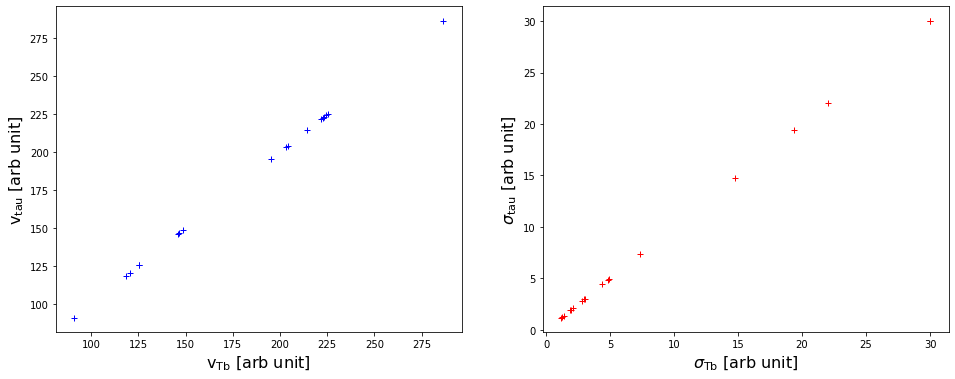

In [43]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(params[:,0][1::3], params[:,1][1::3], "+b")
plt.xlabel(r"v$_{\rm Tb}$ [arb unit]", fontsize=16)
plt.ylabel(r"v$_{\rm tau}$ [arb unit]", fontsize=16)
plt.subplot(1,2,2)
plt.plot(params[:,0][2::3], params[:,1][2::3], "+r")
plt.xlabel(r"$\sigma_{\rm Tb}$ [arb unit]", fontsize=16)
plt.ylabel(r"$\sigma_{\rm tau}$ [arb unit]", fontsize=16)



Text(0.5, 0, 'v [km s$^{-1}$]')

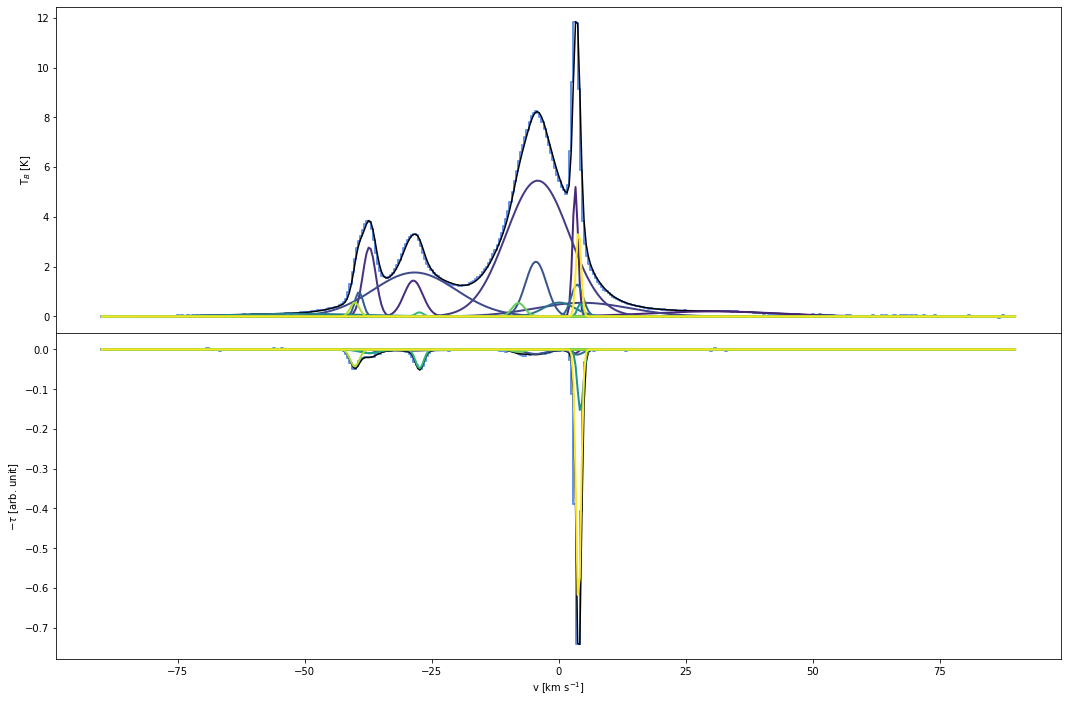

In [49]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
model_cube = core.model(params, cube, n_gauss)

#Plot                                                                                                                                                                                                                                                                         
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(18,12))
fig.subplots_adjust(hspace=0.)
x = np.arange(cube.shape[0])
ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
ax1.plot(v, model_cube[:,0], color='k')
ax2.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
ax2.plot(v, -model_cube[:,1], color='k')
for i in np.arange(cube.shape[1]):
    for k in np.arange(n_gauss):
        line = core.gaussian(x, params[0+(k*3),i], params[1+(k*3),i], 
                              params[2+(k*3),i])
        if i == 1:
            ax2.plot(v, -line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)
        else:
            ax1.plot(v, line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)

ax1.set_ylabel(r'T$_{B}$ [K]')
ax2.set_ylabel(r'$- \tau$ [arb. unit]')
ax2.set_xlabel(r'v [km s$^{-1}$]')
